# Statistische Analyse der Vergleichbarkeit von ICF-Körben, die über WHODAS und Coresets befüllt werden

In [2]:
import pandas as pd
from collections import Counter
import itertools

Einlesen der WHODAS-ICF und Contextfaktoren ICFs (=Env), Erzeugen eines Dataframes mit den Spalten "whodas" und "env"

In [3]:
whodas=pd.read_json('data/whodas12_de.json')
env=pd.read_json('data/env_factors_de.json')
df=pd.DataFrame(columns=['whodas'])
df['whodas']=list(itertools.chain.from_iterable( [x.split(',') for x in whodas.loc['l']]))
elist=list(itertools.chain.from_iterable( [x.split(',') for x in env.loc['l']]))
df=pd.concat([df,pd.Series(elist,name='env').to_frame()],axis=1)
df=df[df['whodas']!='']
df=df[df['env']!='']

Einlesen der Coreset-ICFs. Zusammenführen der Dataframes

In [4]:
coresets = pd.read_json('data/coresets.json')
a=[]
for c in coresets.columns:
    l=coresets.loc['items',c]
    a.append(pd.Series(l,name='coreset_'+c))
    
df2=pd.concat(a, axis='columns',ignore_index=False)

In [5]:
df3=pd.concat([df,df2],axis='columns',ignore_index=False)

In [6]:
df4_whodas=df3.applymap(lambda x: x in df3['whodas'].values)
df4_env=df3.applymap(lambda x: x in df3['env'].values)

## Zahl der gültigen Datensätze
Anzeigen der ICF-Items pro Korb

In [7]:
df3.count()

whodas                     40
env                        35
coreset_generic             7
coreset_rehabilitation     30
coreset_minimal-context    12
coreset_L-Spine            35
coreset_Osteoarthritis     13
coreset_musc-acute         28
coreset_musc-postacute     31
coreset_chronic-pain       24
coreset_osteoporosis       12
coreset_rheuma             20
coreset_khk                19
coreset_diabetes           27
coreset_adipositas          8
coreset_copd               14
coreset_neuro-postacute    38
coreset_depression         31
coreset_work-reha          13
coreset_geriatrie          38
dtype: int64

## Überdeckung von Coreset-ICF-Items mit Whodas und Env Korb
Angezeigt wird der Anteil von Fragen aus Whodas oder Env, die auch im Coreset enthalten sind. (Deterministischer Ansatz)

In [8]:
df4_whodas.apply(lambda x: sum(x)/40)

whodas                     1.000
env                        0.000
coreset_generic            0.075
coreset_rehabilitation     0.300
coreset_minimal-context    0.000
coreset_L-Spine            0.175
coreset_Osteoarthritis     0.050
coreset_musc-acute         0.125
coreset_musc-postacute     0.175
coreset_chronic-pain       0.150
coreset_osteoporosis       0.050
coreset_rheuma             0.050
coreset_khk                0.125
coreset_diabetes           0.025
coreset_adipositas         0.050
coreset_copd               0.075
coreset_neuro-postacute    0.175
coreset_depression         0.125
coreset_work-reha          0.125
coreset_geriatrie          0.175
dtype: float64

In [9]:
df4_env.apply(lambda x: sum(x)/35)

whodas                     0.000000
env                        1.000000
coreset_generic            0.000000
coreset_rehabilitation     0.000000
coreset_minimal-context    0.257143
coreset_L-Spine            0.142857
coreset_Osteoarthritis     0.114286
coreset_musc-acute         0.028571
coreset_musc-postacute     0.114286
coreset_chronic-pain       0.057143
coreset_osteoporosis       0.057143
coreset_rheuma             0.114286
coreset_khk                0.000000
coreset_diabetes           0.171429
coreset_adipositas         0.057143
coreset_copd               0.114286
coreset_neuro-postacute    0.114286
coreset_depression         0.114286
coreset_work-reha          0.114286
coreset_geriatrie          0.114286
dtype: float64

## Verteilungsmatrix

In [10]:
all_icf_items=list(itertools.chain.from_iterable( [df3[s].dropna().to_list() for s in df3]))

In [11]:
# Zahl aller verwendeten ICF Items in allen Körben
cnt = Counter()
for text in all_icf_items:
    cnt[text] += 1
    
len(cnt)

173

In [12]:
# die 10 häufigsten
commons = cnt.most_common(10)

In [90]:
commons

[('d450', 15),
 ('e110', 11),
 ('e355', 11),
 ('e310', 10),
 ('b455', 10),
 ('d240', 10),
 ('e580', 9),
 ('b130', 9),
 ('b280', 9),
 ('d850', 8)]

In [13]:
# Erzeugen der Häufigkeitsmatrix als Dataframe
df_weights=df3.applymap(lambda x: cnt[x])
df_weights.style.background_gradient(cmap='Blues')

,whodas,env,coreset_generic,coreset_rehabilitation,coreset_minimal-context,coreset_L-Spine,coreset_Osteoarthritis,coreset_musc-acute,coreset_musc-postacute,coreset_chronic-pain,coreset_osteoporosis,coreset_rheuma,coreset_khk,coreset_diabetes,coreset_adipositas,coreset_copd,coreset_neuro-postacute,coreset_depression,coreset_work-reha,coreset_geriatrie
0,6,1,9,9,11,9,9,9,5,9,7,9,9,9,9,2,1,1,9,5
1,2,1,7,5,8,5,1,7,1,5,9,10,7,2,4,2,1,1,2,2
2,1,1,9,7,4,7,7,3,9,2,5,5,9,1,10,10,1,1,10,10
3,5,4,8,9,2,9,4,2,2,7,7,7,2,2,15,3,2,1,4,3
4,1,1,15,10,3,10,5,10,4,1,4,2,3,3,6,8,1,1,10,5
5,2,1,6,5,3,5,3,1,5,9,15,8,3,3,6,15,2,1,2,1
6,4,1,8,1,4,1,3,5,7,10,4,7,10,10,11,6,3,2,4,1
7,2,2,0,5,10,7,15,5,4,7,11,2,3,4,10,5,2,1,8,8
8,5,1,0,7,3,2,6,2,1,1,11,3,4,1,0,11,1,1,2,1
9,1,1,0,8,11,4,8,10,2,5,9,15,8,1,0,8,4,1,10,7


In [14]:
# Normalisieren der Gewichte auf die Korbgröße (Column). Zahlen über 2 besagen, dass im Durchschnitt, jedes Item nochmal in einem anderen Korb zu finden ist.
df_weights.apply(lambda x: sum(x)/len(x))

whodas                     2.976744
env                        2.186047
coreset_generic            1.441860
coreset_rehabilitation     4.209302
coreset_minimal-context    1.697674
coreset_L-Spine            4.790698
coreset_Osteoarthritis     1.930233
coreset_musc-acute         3.581395
coreset_musc-postacute     4.116279
coreset_chronic-pain       3.534884
coreset_osteoporosis       2.093023
coreset_rheuma             3.093023
coreset_khk                2.790698
coreset_diabetes           3.093023
coreset_adipositas         1.651163
coreset_copd               1.930233
coreset_neuro-postacute    3.488372
coreset_depression         2.488372
coreset_work-reha          1.744186
coreset_geriatrie          3.976744
dtype: float64

# Monte Carlo Simulation
Aufgabe: Jeder Spieler zieht 5 (3,6,7...) ICF Items aus dem Korb. Mit welcher Wahrscheinlichkeit überdeckt sich die Auswahl aus Whodas oder Env mit einer Ziehung aus den anderen Körben mindestens zu 50% (70,80,90%..) ?

In [15]:
import random
import numpy as np
itemnumber=10
tosses=100
results = {}
for c in df3.columns:
    a=[]
    for i in range(tosses):
        l_w=random.choices(df3['whodas'].to_list()+df3['env'].to_list(),weights=df_weights['whodas'].to_list()+df_weights['env'].to_list(), k=itemnumber)
        l2=random.choices(df3[c].to_list(),weights=df_weights[c].to_list(), k=itemnumber)
        a.append(sum([x in l_w for x in l2])/itemnumber)
    results[c]=a


In [16]:
for (k,v) in results.items():
    print('Überdeckung von %s mit Whodas+Env: %.2f'%(k,np.mean(v)))

Überdeckung von whodas mit Whodas+Env: 0.24
Überdeckung von env mit Whodas+Env: 0.20
Überdeckung von coreset_generic mit Whodas+Env: 0.20
Überdeckung von coreset_rehabilitation mit Whodas+Env: 0.11
Überdeckung von coreset_minimal-context mit Whodas+Env: 0.23
Überdeckung von coreset_L-Spine mit Whodas+Env: 0.14
Überdeckung von coreset_Osteoarthritis mit Whodas+Env: 0.22
Überdeckung von coreset_musc-acute mit Whodas+Env: 0.12
Überdeckung von coreset_musc-postacute mit Whodas+Env: 0.14
Überdeckung von coreset_chronic-pain mit Whodas+Env: 0.11
Überdeckung von coreset_osteoporosis mit Whodas+Env: 0.20
Überdeckung von coreset_rheuma mit Whodas+Env: 0.15
Überdeckung von coreset_khk mit Whodas+Env: 0.11
Überdeckung von coreset_diabetes mit Whodas+Env: 0.14
Überdeckung von coreset_adipositas mit Whodas+Env: 0.26
Überdeckung von coreset_copd mit Whodas+Env: 0.23
Überdeckung von coreset_neuro-postacute mit Whodas+Env: 0.17
Überdeckung von coreset_depression mit Whodas+Env: 0.12
Überdeckung von co

In [17]:
print('Durchschnittliche Überdeckung %f (Std: %f)'%(np.mean([np.mean(x) for x in results.values()]),np.mean([np.std(x) for x in results.values()])))

Durchschnittliche Überdeckung 0.168100 (Std: 0.146543)


In [18]:
import statsmodels.api as sm
res_means=[]
for (k,v) in results.items():
    effectsize=sm.stats.proportion_effectsize(0.5,np.mean(v))
    analysis=sm.stats.TTestIndPower()
    result = analysis.solve_power(effect_size=effectsize, alpha=0.05, power=0.95,alternative='larger')
    print('Effektgröße: %.3f; Stichprobengröße für %s: %.0f' %(effectsize,k,result))
    res_means.append(result)
    
print('Durchschnittliche Fallzahl %.1f, Std: %.2f'%(np.mean(res_means),np.std(res_means)))

Effektgröße: 0.549; Stichprobengröße für whodas: 72
Effektgröße: 0.651; Stichprobengröße für env: 52
Effektgröße: 0.651; Stichprobengröße für coreset_generic: 52
Effektgröße: 0.895; Stichprobengröße für coreset_rehabilitation: 28
Effektgröße: 0.563; Stichprobengröße für coreset_minimal-context: 69
Effektgröße: 0.812; Stichprobengröße für coreset_L-Spine: 33
Effektgröße: 0.602; Stichprobengröße für coreset_Osteoarthritis: 60
Effektgröße: 0.857; Stichprobengröße für coreset_musc-acute: 30
Effektgröße: 0.801; Stichprobengröße für coreset_musc-postacute: 34
Effektgröße: 0.879; Stichprobengröße für coreset_chronic-pain: 29
Effektgröße: 0.649; Stichprobengröße für coreset_osteoporosis: 52
Effektgröße: 0.784; Stichprobengröße für coreset_rheuma: 36
Effektgröße: 0.888; Stichprobengröße für coreset_khk: 28
Effektgröße: 0.804; Stichprobengröße für coreset_diabetes: 34
Effektgröße: 0.510; Stichprobengröße für coreset_adipositas: 84
Effektgröße: 0.561; Stichprobengröße für coreset_copd: 69
Effektg

/Users/peterbernstein/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: invalid value encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)


(array([30.,  0., 33.,  0., 21., 13.,  0.,  0.,  2.,  1.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ]),
 <BarContainer object of 10 artists>)

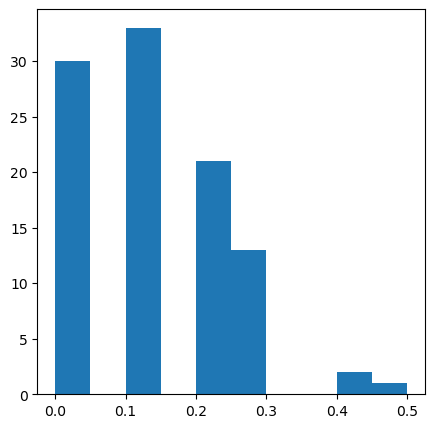

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax=plt.subplots(figsize=(5,5))
ax.hist(results['coreset_rehabilitation'], bins=10)

In [30]:
from scipy import stats
res = stats.ttest_ind(results['coreset_rehabilitation'], m1['coreset_rehabilitation'],equal_var=False)
print(f'p-Wert für einseitigen Test: {res.pvalue / 2:.4f}')

p-Wert für einseitigen Test: 0.0000


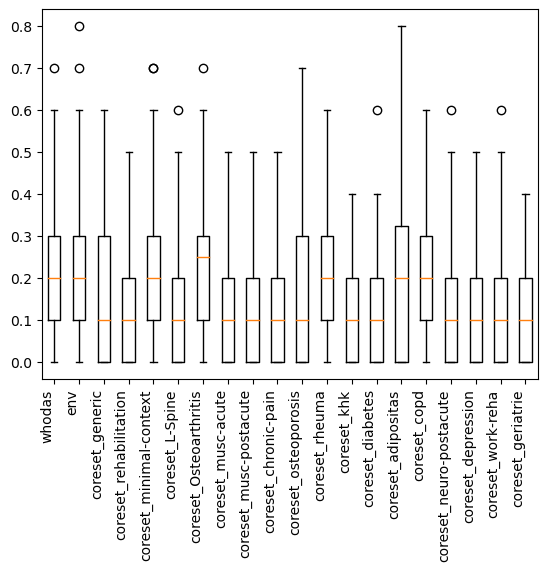

In [48]:

plt.boxplot(results.values(), labels=results.keys())
plt.xticks(rotation=90, ha='right')
plt.savefig('results/montecarlo-distribution.png',bbox_inches='tight',pad_inches=1)